# Criação do Pacote para o Aplicativo de Análise de Attrition

## Bibliotecas Utilizadas

In [1]:
# Bibliotecas de Sistema
import glob
import os
from zipfile import ZipFile
from copy import deepcopy
from pathlib import Path
from abc import ABC, abstractmethod
from __future__ import annotations
from typing import Dict, List, Tuple, Any
import warnings

# Manipulação de Dados
import pandas as pd
import numpy as np


#  Estatística
from scipy.stats import kendalltau
from statsmodels.stats.weightstats import ztest
from scipy.stats import chisquare

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import shap

# Processamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder


# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek


# Modelo
## Métricas de Validação
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## Validação Cruzada e GridSearch
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## Modelo em Árvore
import lightgbm as lgb





# Configurações Globais

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style='darkgrid')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)


## Importação de Dados

In [2]:
data = pd.read_csv("attrition_data1.csv")

data.loc[data["Attrition"]=="Yes", "Attrition"] = 1
data.loc[data["Attrition"] == "No", "Attrition"] = 0
data[["Attrition"]] = data[["Attrition"]].astype("int")

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Attrition'), data['Attrition'], test_size=0.2, random_state=13)

## Construção das Funcionalidades

In [3]:
# Classes Abstratas


class NumericalProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
      pass


class CategoricalProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
    pass

class NaNProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
    pass

class Model(ABC):
  @abstractmethod
  def fit(self, x_train, y_train):
    pass

  @abstractmethod
  def predict(self, x_test, y_test):
    pass

  @abstractmethod
  def predict_proba(self, x_test):
    pass

  @abstractmethod
  def score(self):
    pass

In [77]:
# Classes Concretas

class DataAttrition:
  """
  Classe criada para adaptar diversas formatos de arquivos e bases de dados\n
  para ser trabalhada na aplicação.

  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada. Podendo ser recebido a base de dados do pandas,\n
    ou o caminho de um arquivo, sendo possível ler e transformar as seguintes extensões\n
    em dataframe: csv, xlsx, xls, json e parquet.
  """
  def __init__(self, data: pd.DataFrame | Path | str) -> None:
    
    try:
      if isinstance(data, pd.DataFrame):
        self.data_frame = data
      elif isinstance(data, Path):
        self.data_frame = pd.read_csv(data.__str__())
      else:
        df_path_extension = os.path.splitext(data)[-1]
        if df_path_extension == '.csv':
          self.data_frame = pd.read_csv(data)
        elif df_path_extension == '.xlsx' or df_path_extension == '.xls':
          self.data_frame = pd.read_excel(data)
        elif df_path_extension == '.json':
          self.data_frame = pd.read_json(data)
        elif df_path_extension == '.parquet':
          self.data_frame = pd.read_parquet(data)
        else:
          raise ValueError('Extensão de arquivo não suportada.')

    except ValueError as e:
        print('O dado inserido é inválido.', e)


  def train_test_model_data(self, target_variable, test_size=0.2, random_state=0):
    x_train, x_test, y_train, y_test = train_test_split(self.data_frame.drop(columns=target_variable),
    self.data_frame[target_variable], test_size=test_size, random_state=random_state)
    return x_train, x_test, y_train, y_test
        

      
class AttNumProcess(NumericalProcessor):
  """
  Classe criada para trabalhar com dados numéricos.\n
  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada.
  
  """
  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame.select_dtypes(include=np.number).drop(columns=['Attrition'])

  
  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame

  def process(self, data=None, strategy='standard_scaler') -> pd.DataFrame:
    """
    Método para processar os dados numéricos.\n
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia de normalização.\n
    Opções:
    -------
    standard_scaler: StandardScaler
      Normalização padrão.
    min_max_scaler: MinMaxScaler
      Normalização de escala de 0 a 1.
    robust_scaler: RobustScaler
      Normalização de escala que utiliza estatísticas robustas a outliers.

    """

    #---------------------------------------------------------------#
    # Carrega a base de dados passada como argumento para o cálculo.

    if data is not None:
      self.__init__(data)

    #---------------------------------------------------------------#
    # Estratégias de normalização

    if strategy == 'standard_scaler':
      scaler = StandardScaler()
    elif strategy == 'min_max_scaler':
      scaler = MinMaxScaler()
    elif strategy == 'robust_scaler':
      scaler = RobustScaler()
    else:
      raise ValueError('Não foi possível encontrar a estratégia de normalização.')

    #---------------------------------------------------------------#
    # Normalização dos dados

    self.df_scaled = scaler.fit_transform(self._data_frame)
    self.df_scaled = pd.DataFrame(self.df_scaled, columns=self._data_frame.columns)
    return self.df_scaled



class AttCatProcess(CategoricalProcessor):
  """
  Classe criada para trabalhar com dados categóricos.\n
  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada.

  """

  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame.select_dtypes(include=['object'])

  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame

  @data_frame.setter
  def set_data_frame(self, data: pd.DataFrame):
    self._data_frame = data
  
  def clean_cat(self, data=None) -> pd.DataFrame:
    """
    Função que exclui variáveis categóricas com dado único.
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    """
    if data is not None:
      self.__init__(data)
    for column in self.data_frame.columns:
      if self.data_frame[column].nunique() == 1:
        self.set_data_frame.drop(column, axis=1, inplace=True)
    return self.data_frame
    
    

  def process(self, data=None, strategy='one_hot') -> pd.DataFrame:
    """
    Método para realizar o encoder dos dados categóricos.\n
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia para a realização do encoder.\n
    Opções:
    -------
    one_hot: OneHotEncoder
      Realiza o encode nos valores das variáveis categóricas transformando-os\n
      em colunas de valores binários.
    label: LabelEncoder
      Realiza o encode nos valores das variáveis categóricas transformando-os\n
      em valores numéricos de 0 a numero_de_valores_da_classe-1.
    count_freq: CountFrequencyEncoder
      Substitui os valores categóricos pela porcentagem de ocorrência dos valores na categoria.
    """

    #---------------------------------------------------------------#
    # Caso um dataset seja passado no argumento, este será carregado na função\n
    # para a realização do cálculo.
    if data is not None:
      self.__init__(data)
    
    #---------------------------------------------------------------#
    # Estratégias de encoder

    # self.clean_cat(self.data_frame)
    if strategy == 'one_hot':
      encoder = OneHotEncoder(drop_last=True)
    elif strategy == 'label':
      encoder = LabelEncoder()
    elif strategy == 'count_freq':
      encoder = CountFrequencyEncoder(encoding_method='frequency')
    else:
      raise ValueError('Não foi possível encontrar a estratégia para realizar o encoder.')

    #---------------------------------------------------------------#
    # Encoder dos dados
    self.df_encoded = encoder.fit_transform(self.data_frame)
    return self.df_encoded
    

#------------------------------------------------------------------------#



#------------------------------------------------------------------------#

class AttNaNProcess(NaNProcessor):
  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame
    
  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame
  
  @data_frame.setter
  def set_data_frame(self, data: pd.DataFrame):
    self._data_frame = data

  def process(self, data=None, strategy='drop') -> pd.DataFrame:
    """
    Função para processar dados faltantes.
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia para a realização do cálculo.\n
    Opções:
    -------
    drop: Drop
      Exclui as variáveis que contém dados faltantes.
    fill_mean:
      Substitui os dados numéricos faltantes pela média.
    fill_mode: 
      Substitui os dados numéricos faltantes pela moda.
    fill_median:
      Substitui os dados numéricos faltantes pela mediana.
    fill_mode_cat:
      Substitui os dados categóricos faltantes pela moda.

    """

    #---------------------------------------------------------------#
    # Caso um dataset seja passado no argumento, este será carregado na função\n
    # para a realização do cálculo.
    if data is not None:
      self.__init__(data)

    #---------------------------------------------------------------#
    # Separa o dado entre variáveis numéricas e categóricas
    num_data_frame = self.data_frame.select_dtypes(include=np.number).drop(columns='Attrition')
    cat_data_frame = self.data_frame.select_dtypes(include=['object'])

    
    #---------------------------------------------------------------#
    # Estratégias de processamento
    if strategy == 'drop':
      self.set_data_frame.dropna(inplace=True, axis=1)
      return self.data_frame

    elif strategy == 'fill_mean':
      num_data_frame.fillna(self.data_frame.mean(), inplace=True)
      self.set_data_frame[num_data_frame.columns] = num_data_frame
      return self.data_frame


    elif strategy == 'fill_mode':
      num_data_frame.fillna(num_data_frame.mode().iloc[0], inplace=True)
      self.set_data_frame[num_data_frame.columns] = num_data_frame
      return self.data_frame

    elif strategy == 'fill_median':
      self.set_data_frame.fillna(self.data_frame.median(), inplace=True)
      return self.data_frame

    elif strategy == 'fill_mode_cat':
      cat_data_frame.fillna(cat_data_frame.mode().iloc[0], inplace=True)
      self.set_data_frame[cat_data_frame.columns] = cat_data_frame
      return self.data_frame
    else:
      raise ValueError('Não foi possível encontrar a estratégia de imputação.')


#------------------------------------------------------------------------#



#------------------------------------------------------------------------#





class AttModel(Model):
  def __init__(self, model, params=None) -> None:
    self.model = model
    self.prediction = None
    self.prediction_proba = None
    self._target_variable = 'Attrition'
    self._data_importance = None
    self._data_corr = None
    self._corr_importance = None
    self.strategy = 'one_hot'
    if params is not None:
      self.params = params
      self.model.set_params(**self.params)


  def get_name(self) -> str:
    return self.__class__.__name__


  @property
  def target_variable(self) -> str:
    return self._target_variable

  @target_variable.setter
  def set_target_variable(self, target_variable: str):
    self._target_variable = target_variable



  @property
  def data_importance(self) -> pd.DataFrame:
    return self._data_importance

  @data_importance.setter
  def set_data_importance(self, data_importance: pd.DataFrame):
    self._data_importance = data_importance

  @property
  def data_corr(self) -> pd.DataFrame:
    return self._data_corr

  @data_corr.setter
  def set_data_corr(self, data_corr: pd.DataFrame):
    self._data_corr = data_corr


  @property
  def corr_importance(self) -> pd.DataFrame:
    return self._corr_importance

  @corr_importance.setter
  def set_corr_importance(self, corr_importance: pd.DataFrame):
    self._corr_importance = corr_importance
  


  def fit(self, x_train: pd.Series | np.ndarray | List[np.number],
   y_train: pd.Series | np.ndarray | List[np.number]) -> None:
    self.model.fit(x_train, y_train)

    

  
  def predict(self, x_test: pd.Series | np.ndarray | List[np.number])-> List[Any]:
    self.prediction = self.model.predict(x_test)
    return self.prediction

  
  def predict_proba(self, x_test: pd.Series | np.ndarray | List[np.number]) -> List[Any]:
    self.prediction_proba = self.model.predict_proba(x_test)
    return self.prediction_proba

  
  def score(self, x_test, y_test, metrics='accuracy'):
    self.predict(x_test)
    if metrics == 'accuracy':
      return self.model.score(x_test, y_test)

    elif metrics == 'roc_auc':
      return roc_auc_score(self.prediction, y_test)

    else:
      raise ValueError('Metrica inserida é inválida.')


  def train_test_data(func):
    def decorator(self, data):
      df = func(self, data)
      df = DataAttrition(df).train_test_model_data(target_variable=self.target_variable)
      return df

    decorator.unwrapped = func
    
    return decorator


  @train_test_data
  def _data_to_clean(self, data):
    df = deepcopy(data)
      
    # data_cat_cols = df.select_dtypes(include=['object']).columns

    # df[data_cat_cols] = AttCatProcess().process(df, strategy=self.strategy)

    try:

      df_cols = df.select_dtypes(include=['object']).columns.tolist()

      # pd.concat(df, AttCatProcess().process(df, strategy='one_hot'))

      treated_df = AttCatProcess().process(df[df_cols], strategy='one_hot')

      df.drop(columns=df_cols, inplace=True)


      df = df.merge(treated_df, left_index=True, right_index=True)
      return df
    except:
      return df



  def _feature_analysis(self, data): 
    if self.data_importance is not None:
      return self.data_importance
    
    data_use = self._data_to_clean(data)



    lgb_classifier = lgb.LGBMClassifier()

    lgb_classifier.fit(data_use[0], data_use[2])

    importance = lgb_classifier.feature_importances_


    feat_import = permutation_importance(lgb_classifier, data_use[0], data_use[2], 
    n_repeats=30, random_state=13, n_jobs=-1)
    importance = feat_import.importances_mean
    self.set_data_importance = pd.DataFrame({'feature': data_use[0].columns, 'importance': importance})

    return self.data_importance


  def _correlation_analysis(self, data):

    data = self._data_to_clean.unwrapped(self, data)
    self.set_data_corr = data.corr()[[self.target_variable]].drop(self.target_variable).reset_index().rename(columns={'index': 'feature', self.target_variable: 'correlation'})
    
    # corr_target = corr[self.target_variable]
    # corr_target = corr_target.drop(self.target_variable)

    # self.set_data_corr_importance = pd.concat([self.data_importance, corr], axis=1)
    # return self.data_corr_importance
    return self.data_corr


  def _join_corr_importance(self, data=None):
    if data is not None:
      if self.data_importance is None:
        self._feature_analysis(data)
      if self.data_corr is None:
        self._correlation_analysis(data)
    else:
      raise ValueError('Insira um dataframe para realizar a análise.')

    self.set_corr_importance = self.data_importance.merge(self.data_corr, on='feature')

    return self.corr_importance


  def auto_learning(self, data):
    if self.model.__class__.__name__ != 'LGBMClassifier':
      return self.model

    data = self._data_to_clean(data)
    auto_param = {'init_model': self.model}
    self.model.fit(data[0], data[2], **auto_param)
  



class AttAnalytics:

  def __init__(self, model: Model, data=None) -> None:
    self.model = model
    self.data = data


  def _set_risk_group(self, trained_model, x) -> np.ndarray:
    proba_pred = self.model.predict_proba(x)

    median_pred = np.median(proba_pred)
    _1st_quantile = np.quantile(proba_pred, 0.25)
    _3rd_quantile = np.quantile(proba_pred, 0.75)
    interquantile_range = _3rd_quantile - _1st_quantile

    high_risk_lim = _3rd_quantile + (1.5 * interquantile_range)


    proba = trained_model.predict_proba(x)[:, 1]
    return np.where(proba <= median_pred, 'low_risk',
    np.where(proba <= _3rd_quantile, 'medium_risk',
    np.where(proba <= high_risk_lim, 'high_risk', 'severe_risk')))

  def analytics(self, data):
    pass





## Teste das Funcionalidades

In [69]:
df = deepcopy(data)

df_cols = df.select_dtypes(include=['object']).columns.tolist()

# pd.concat(df, AttCatProcess().process(df, strategy='one_hot'))

treated_df = AttCatProcess().process(df[df_cols], strategy='one_hot')

df.drop(columns=df_cols, inplace=True)


df = df.merge(treated_df, left_index=True, right_index=True)

In [47]:
np.sort(data['StockOptionLevel'].unique())
# data['EmployeeNumber'].value_counts()

array([0, 1, 2, 3], dtype=int64)

In [76]:
df.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Rarely', 'BusinessTravel_Travel_Frequently',
       'Department_Sales', 'Department_Research & Development',
       'EducationField_Life Sciences', 'EducationField_Other',
       'EducationField_Medical', 'EducationField_Marketing',
       'EducationField_Technical Degree', 'Gender_Female',
       'JobRole_Sales Executive', 'JobRole_Research Scientist',
       'JobRole_Laboratory Technician', 'JobRole_M

In [78]:
params = {'boosting_type': 'gbdt', 
          'num_leaves': 100,
          'max_depth':  100,
          'learning_rate':  0.1,
          'n_estimators':  200}

att_model = AttModel(model=lgb.LGBMClassifier(), params=params)


In [79]:
feat_test_value = att_model._feature_analysis(data=data)
x_train, x_test, y_train, y_test = att_model._data_to_clean(data=data)

most_important = feat_test_value.sort_values(by='importance', ascending=False)
most_important = most_important[:10].values
most_important = most_important[:, 0].tolist()


lgb_model_test = lgb.LGBMClassifier().fit(x_train[most_important], y_train)

In [80]:
# explainer = shap.Explainer(lgb_model_test.predict,x_train[most_important], feature_names=most_important)
explainer = shap.Explainer(lgb_model_test, x_train[most_important], feature_names=most_important, algorithm='tree')
shap_values = explainer(x_test[most_important])

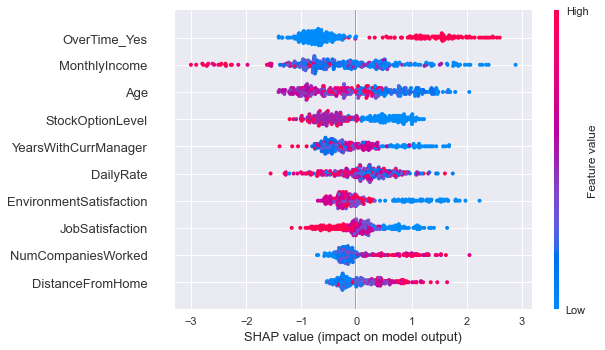

In [81]:
shap.plots.beeswarm(shap_values)

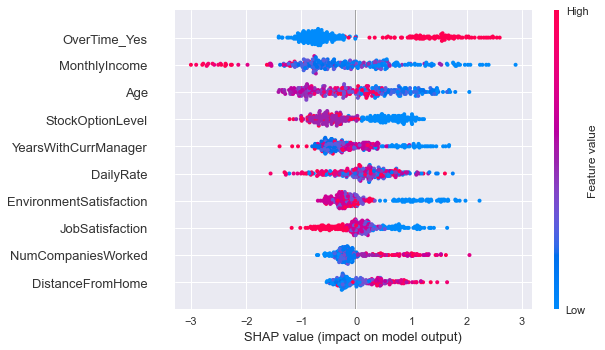

In [82]:
shap.summary_plot(shap_values, x_test[most_important])

In [11]:
explainer(x_test[most_important])

.values =
array([[-0.72381311,  0.13640456,  0.55814345, ...,  0.13612396,
         0.08107867,  0.56792719],
       [-0.9777949 ,  0.60744215, -0.28665433, ...,  0.74694233,
         0.37265203, -0.63634963],
       [ 1.54746796, -0.59339742, -0.4060693 , ...,  0.77664213,
         1.01138749, -0.56655583],
       ...,
       [ 1.24377287,  0.70553514, -1.15704173, ..., -0.23647678,
        -0.26744646,  0.14109054],
       [-0.96030995,  0.26682439, -0.79272441, ..., -0.69270397,
        -0.2907536 ,  0.726517  ],
       [ 1.19684816, -0.69458324, -1.11773645, ...,  0.68684784,
        -0.43183124,  1.18663617]])

.base_values =
array([-3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
 

In [12]:
shap_values.feature_names

['OverTime',
 'StockOptionLevel',
 'MonthlyIncome',
 'JobSatisfaction',
 'NumCompaniesWorked',
 'Age',
 'EnvironmentSatisfaction',
 'DailyRate',
 'DistanceFromHome',
 'YearsWithCurrManager']

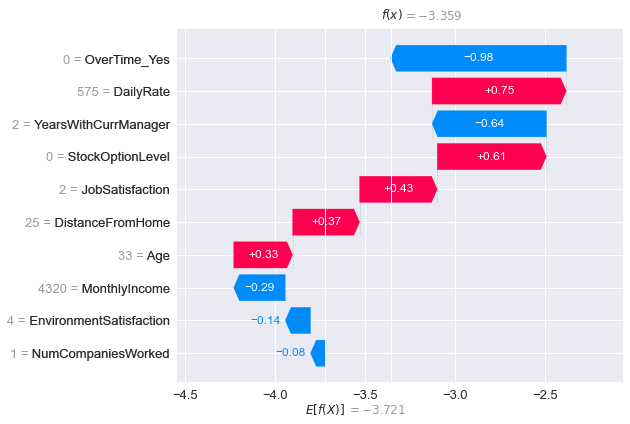

.values =
array([-0.9777949 , -0.28665433, -0.08285306, -0.14055312,  0.43173329,
        0.32771161,  0.74694233, -0.63634963,  0.37265203,  0.60744215])

.base_values =
-3.7209983230943466

.data =
array([   0, 4320,    1,    4,    2,   33,  575,    2,   25,    0],
      dtype=int64)


In [83]:
i = 1

shap.plots.waterfall(shap_values[i])
print(shap_values[i])

In [14]:
shap_values[0]

.values =
array([-0.72381311,  0.13640456,  0.55814345, -0.58515658, -0.16687924,
       -0.58882899, -0.28048321,  0.13612396,  0.08107867,  0.56792719])

.base_values =
-3.7209983230943466

.data =
array([7.17006803e-01, 0.00000000e+00, 9.98000000e+03, 4.00000000e+00,
       1.00000000e+00, 3.60000000e+01, 2.00000000e+00, 6.35000000e+02,
       1.00000000e+01, 7.00000000e+00])